# Sample Hardness
We will look at dataset difficulty and sample hardness using Iris data

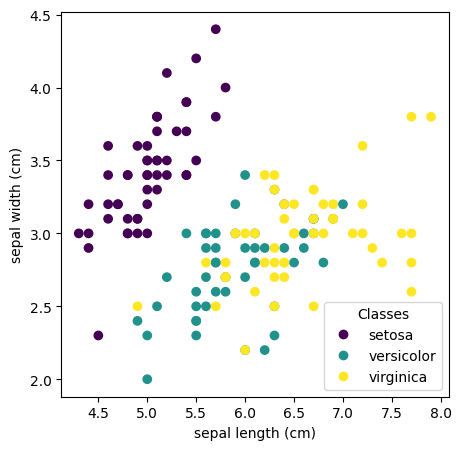

In [84]:
from sklearn.datasets import load_iris
iris = load_iris()

import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

Iris is a relative easy dataset. We will pick two features, and pick _versicolor_ and _virginica_ lables as there seems to be some overalp in the feature space. We will look at this two dimensional data from many angles and see what can we learn about

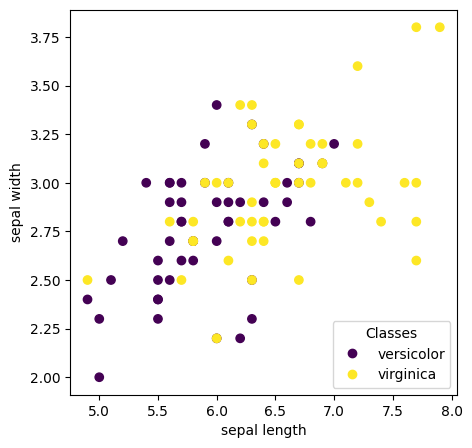

In [85]:

y = iris.target
ind = (y==1) | (y==2)
X = iris.data[ind, 0:2]
y = y[ind]-1

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set(xlabel='sepal length', ylabel='sepal width')
_ = ax.legend(
    scatter.legend_elements()[0], ['versicolor', 'virginica'], loc="lower right", title="Classes"
)

# clean up the variables

We will build a simple linear model (no interactions), then an MLP, use the Linear Model to define sample hardness.
Later, we will remove those points, and retrain an MLP. And see the difference. Along the way, we will see different sample hardness measures.

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

import numpy as np
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
yh_train = clf.predict(X_train)

from sklearn.metrics import classification_report
print('on train set')
print(classification_report(y_train, yh_train, target_names=['versicolor','virginica']))

yh_test = clf.predict(X_test)
print('on test set')
print(classification_report(y_test, yh_test, target_names=['versicolor','virginica']))

on train set
              precision    recall  f1-score   support

  versicolor       0.70      0.76      0.73        41
   virginica       0.72      0.67      0.69        39

    accuracy                           0.71        80
   macro avg       0.71      0.71      0.71        80
weighted avg       0.71      0.71      0.71        80

on test set
              precision    recall  f1-score   support

  versicolor       0.78      0.78      0.78         9
   virginica       0.82      0.82      0.82        11

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



## RMD
Let us compute the Mahalanobis Distance (MD) and Relative Mahalanobis Distance (RMD) to flag RMD score

1st group (41, 2)
1st group (39, 2)


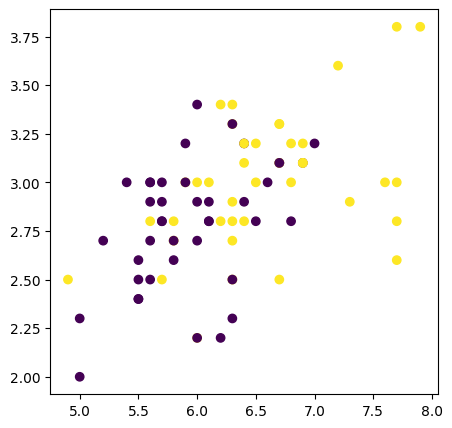

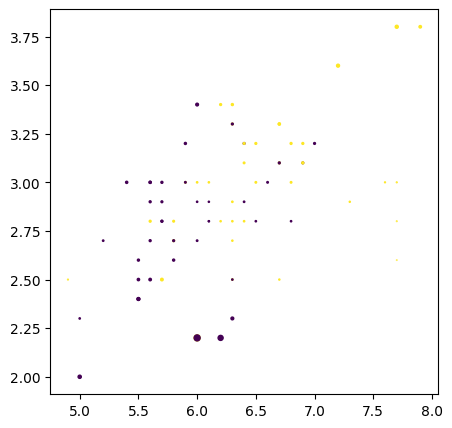

In [87]:
# let us compute RMD for this two features
from sklearn.covariance import EmpiricalCovariance, MinCovDet
X1 = X_train[y_train==0,:]
print('1st group', X1.shape)
X2 = X_train[y_train==1,:]
print('1st group', X2.shape)

Sig1 = MinCovDet().fit(X1)
Sig2 = MinCovDet().fit(X2)
Sig = MinCovDet().fit(X_train)

m1 = Sig1.mahalanobis(X_train)
m2 = Sig2.mahalanobis(X_train)
m = Sig.mahalanobis(X_train)

rmd_1 = (m1-m)
rmd_2 = (m2-m)


# take the min of m1, m2 for each record, subtract m
# min_m1_m2 = np.minimum(m1, m2)
conf_rmd  = -np.minimum(rmd_1, rmd_2)

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=np.exp(conf_rmd))


## Margins
Fit an SVM, and develop a score based on margins


In [88]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)
yh_train = clf.predict(X_train)

y_test = clf.predict(X_test)
print('on test set')
print(classification_report(y_train, yh_train, target_names=['versicolor','virginica']))

print('on test set')
print(classification_report(y_test, yh_test, target_names=['versicolor','virginica']))

on test set
              precision    recall  f1-score   support

  versicolor       0.72      0.71      0.72        41
   virginica       0.70      0.72      0.71        39

    accuracy                           0.71        80
   macro avg       0.71      0.71      0.71        80
weighted avg       0.71      0.71      0.71        80

on test set
              precision    recall  f1-score   support

  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



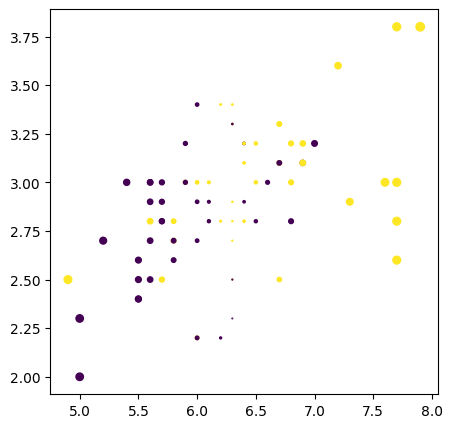

In [89]:
conf = clf.decision_function(X_train)
_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=50*np.abs(conf))

conf scores len 80


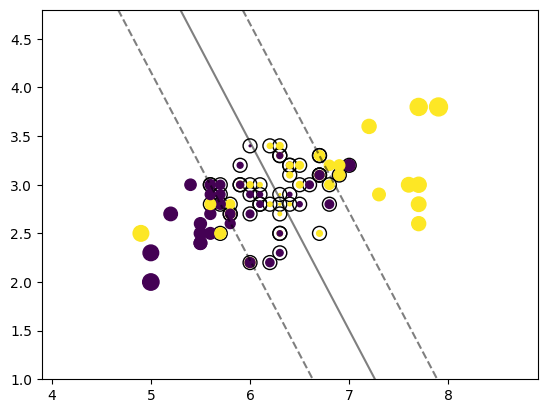

Train size 80
# of support vectors 54


In [90]:
# plot the decision function
from sklearn.inspection import DecisionBoundaryDisplay


from sklearn import svm
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X_train, y_train)

conf = clf.decision_function(X_train)

print('conf scores len', len(conf))

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=50*np.abs(conf))
plt.show()

print('Train size', len(X_train))
print('# of support vectors', len(clf.support_vectors_))

Let us remove the points with low confidence and re-train the model, and at inference time, flag those points with low confidence

In [91]:
# get the smallest confidence that is not of a support vector
sv = clf.support_vectors_

# get the conf of those support vectors
conf_sv = clf.decision_function(sv)
print('support vectors',sv.shape)
print('conf of sv',conf_sv.shape)

# get conf of all points in the train set
conf = clf.decision_function(X_train)
print('conf',conf.shape)

# get the min of max conf of SVs
thresh = np.median(conf_sv)

print('median conf of support vectors is: ', thresh)

# now get all indexes in the training set where conf is more than them and only retain them for model retraining
ind = conf > thresh

support vectors (54, 2)
conf of sv (54,)
conf (80,)
median conf of support vectors is:  -0.16589414579587292


In [92]:
# conf of negative examples
print('neg examples',conf[y_train==0])
print('pos examples',conf[y_train==1])

neg examples [ 1.15547161 -0.35591521 -0.9986464  -1.65188176 -1.00389849 -0.03192357
 -0.92158756 -0.7009152  -2.77797436  0.83673206 -2.53104157  0.74916904
  0.44093366 -0.9986464  -1.41020106 -1.31738595 -1.24557919  0.19400087
  1.39715231 -0.36641939  0.36387482 -0.44347823 -0.45923449  0.83673206
 -1.65188176 -1.00915057 -0.92683964 -0.36641939  0.27105971 -1.4872599
  0.59505135 -1.01965475 -1.56957083 -0.52053707 -0.83927662 -0.60810009
 -1.00389849 -0.28410846 -1.08095733 -0.29461263 -1.88305829]
pos examples [ 0.36387482  0.35862273  0.03463109 -0.04767984  1.00135392  0.83673206
  0.34286647 -0.92683964  0.28681598 -0.3611673   3.00660633 -2.52578948
  0.44618575  2.34811888 -0.52053707 -1.01965475  1.07841276  2.1887491
  3.32534588  0.9137909   0.60030344  0.11168994 -0.20704961 -0.12999077
 -0.29461263 -0.84452871 -1.25083128  0.44093366  2.18349701  1.15547161
  1.62832885  0.43568158  1.15547161  1.00135392  2.04513559 -0.20179752
 -1.16326826  2.01887515  1.23778254]


In [93]:
# At inference time, flag test points as low conf or high conf
conf_test = clf.decision_function(X_test)
ind = conf_test > thresh
print(ind)

[False  True  True False False False  True  True  True  True False  True
  True  True  True  True  True False False False]


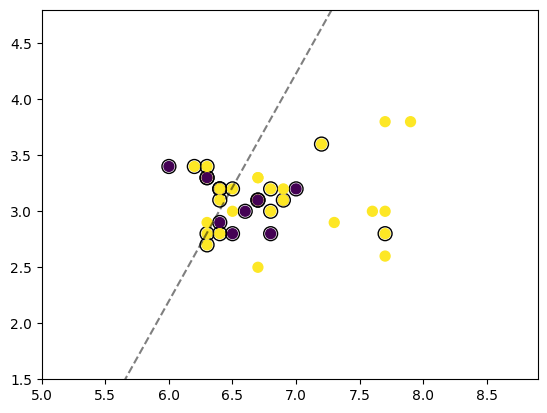

In [94]:
# select high conf points (which are easy) and retrain the model
ind = conf > thresh

X_train_easy = X_train[ind]
y_train_easy = y_train[ind]

clf_easy = svm.SVC(kernel="linear", C=1000)
clf_easy.fit(X_train_easy, y_train_easy)

conf_easy = clf_easy.decision_function(X_train_easy)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf_easy,
    X_train_easy,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf_easy.support_vectors_[:, 0],
    clf_easy.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
ax.scatter(X_train_easy[:, 0], X_train_easy[:, 1], c=y_train_easy,s=50*np.abs(conf_easy))
plt.show()